In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform=None, train = True):
        self.images_per_class = 32 if train else 8
        self.start_image = (~train) * 32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.train = train
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = list(filter(lambda s: s.endswith("jpg"), images))
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label-1])
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms
# torch.__version__
#import torchsample as ts

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler
torch.cuda.current_device()

from torch.optim import lr_scheduler

In [3]:
def validationSplit(trainset, ratio=0.01, random_seed=42):
    trainlen = len(trainset)
    indices = list(range(trainlen))
    split = int(np.floor(ratio*trainlen))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)    
    return train_sampler, valid_sampler

In [75]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Scale((224,224)),
     #torchvision.transforms.Scale(size, interpolation=2),
     #torchvision.transforms.CenterCrop(size),
     #torchvision.transforms.RandomCrop(size, padding=0),
     #torchvision.transforms.RandomSizedCrop(32, interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5)),
    ])

trainset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=True)
testset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=False)
"""
trainloader = DataLoader(
    dataset = caltech256_train,
    batch_size = 128,
    shuffle = True,
    num_workers = 4
)
"""
batch_size=16

train_sampler, valid_sampler = validationSplit(trainset, ratio=0.1)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
class VGG_modified(nn.Module):
    def __init__(self):
        super(VGG_modified, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:])
        self.classifier = nn.Sequential(*list(pretrained_model.classifier.children())[:-1])
        self.lastlayer = nn.Sequential(nn.Linear(4096, 256), nn.ReLU(inplace=True), nn.Softmax())
        
    def forward(self, x):
        out = self.pretrained(x)
#         print(out.size())
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = self.lastlayer(out)
#         print(out.size())
        return out

In [6]:
class VGG_layerfirst_vis(nn.Module):
    def __init__(self):
        super(VGG_layerfirst_vis, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:1])
        
    def forward(self, x):
        out = self.pretrained(x)
        return out

In [7]:
class VGG_layerlast_vis(nn.Module):
    def __init__(self):
        super(VGG_layerlast_vis, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:-2])
        
    def forward(self, x):
        out = self.pretrained(x)
        return out

In [8]:
lastlayer_cnn=VGG_layerlast_vis()
lastlayer_cnn.cuda()

VGG_layerlast_vis (
  (pretrained): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), s

In [9]:
firstlayer_cnn=VGG_layerfirst_vis()
firstlayer_cnn.cuda()

VGG_layerfirst_vis (
  (pretrained): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [96]:
def visualizeImageActivations_1model(model, loader):
    for images, labels in loader:
        images = Variable(images).cuda()
        outputs = model(images).cuda()
        #image_tensor = outputs.data.cpu().numpy()
        image_tensor = outputs.data.cpu()
        return images.cpu(), image_tensor

In [119]:
def visualizeImageActivations(model1, model2, loader):
    for images, labels in loader:
        images = Variable(images).cuda()
        output1 = model1(images).cuda()
        output2 = model2(images).cuda()
        #image_tensor = outputs.data.cpu().numpy()
        image_tensor1 = output1.data.cpu()
        image_tensor2 = output2.data.cpu()
        return images.cpu(), image_tensor1, image_tensor2

In [144]:
images, op1, op2 = visualizeImageActivations(firstlayer_cnn, lastlayer_cnn, trainloader)

In [145]:
images.data.numpy().shape

(16, 3, 224, 224)

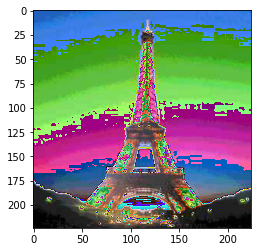

In [161]:
plt.imshow(images.data.numpy()[13].transpose((1, 2, 0)))
plt.show()

In [239]:
grid=torchvision.utils.make_grid(op1[13], nrow=8, padding=1, \
                                 normalize=True, range=None, scale_each=False, pad_value=0)

In [240]:
import matplotlib.gridspec as gridspec

def imshow_gray(inp):
    """Imshow for Tensor."""
    f, axarr = plt.subplots(8,8)
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

    for i in range(64):
        r = i//8
        c = i%8
        axarr[r,c].imshow(inp[i], cmap='gray')
        axarr[r,c].axis('off')
    f.set_size_inches(16,16)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

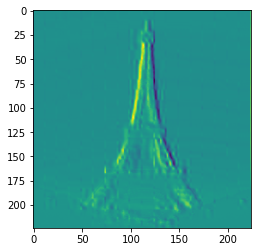

In [241]:
# plt.imshow(grid.numpy()[1], cmap='gray')
plt.imshow(grid.numpy()[0])
plt.show()

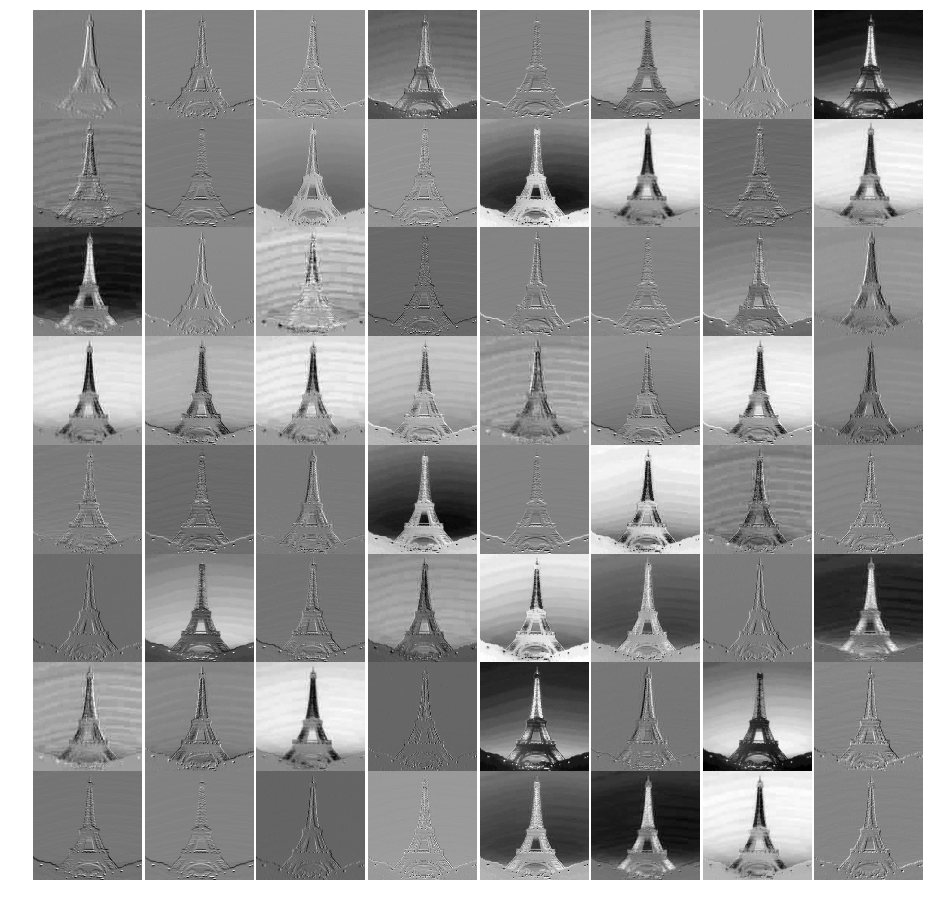

In [242]:
imshow_gray(grid.numpy())

In [187]:
def imshow_gray_last(inp):
    """Imshow for Tensor."""
    f, axarr = plt.subplots(64,8)
    for i in range(512):
        r = i//8
        c = i%8
        axarr[r,c].imshow(inp[i], cmap='gray')
        axarr[r,c].axis('off')
    f.set_size_inches(15, 100)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [251]:
def imshow_gray_last(inp):
    """Imshow for Tensor."""
    for j in range(8):
        f, axarr = plt.subplots(8,8)
        for i,k in zip(range(64), range(j*64, (j+1)*64)):
            r = i//8
            c = i%8
            axarr[r,c].imshow(inp[k], cmap='gray')
            axarr[r,c].axis('off')
        f.set_size_inches(16,16)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [245]:
grid=torchvision.utils.make_grid(op2[13], nrow=8, padding=1, \
                                 normalize=True, range=None, scale_each=False, pad_value=0)

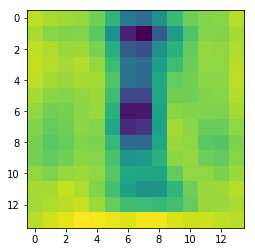

In [249]:
# plt.imshow(grid.numpy()[1], cmap='gray')
plt.imshow(grid.numpy()[0])
plt.show()

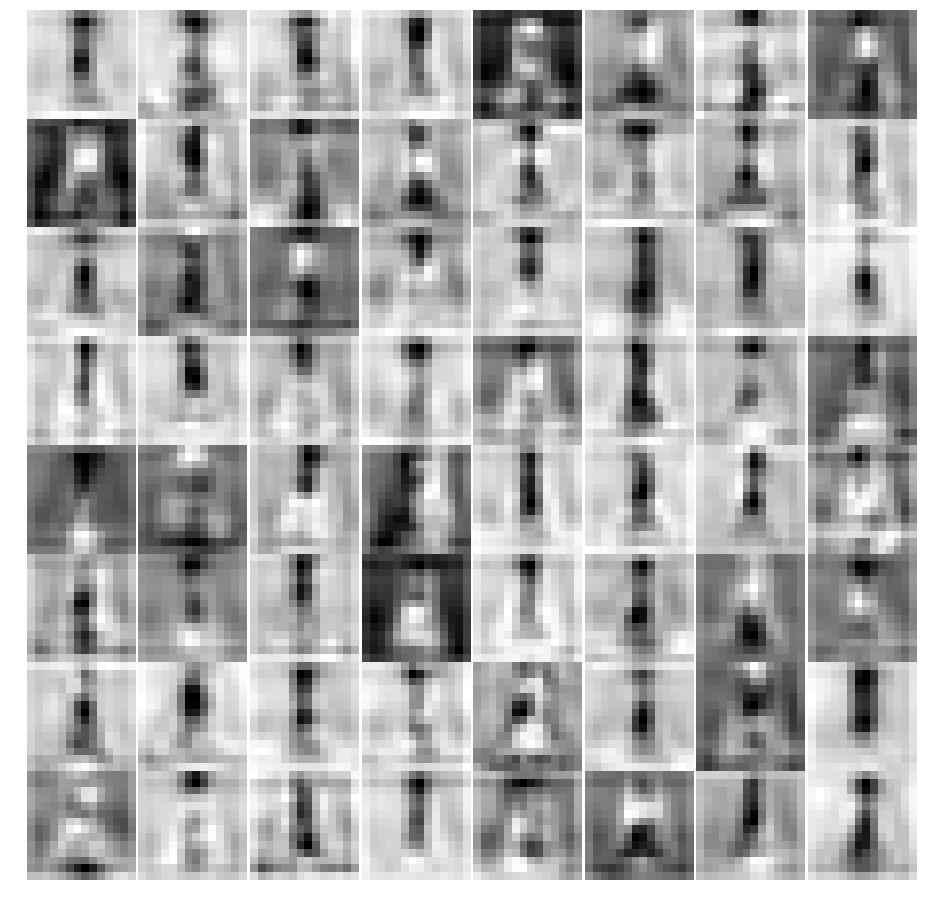

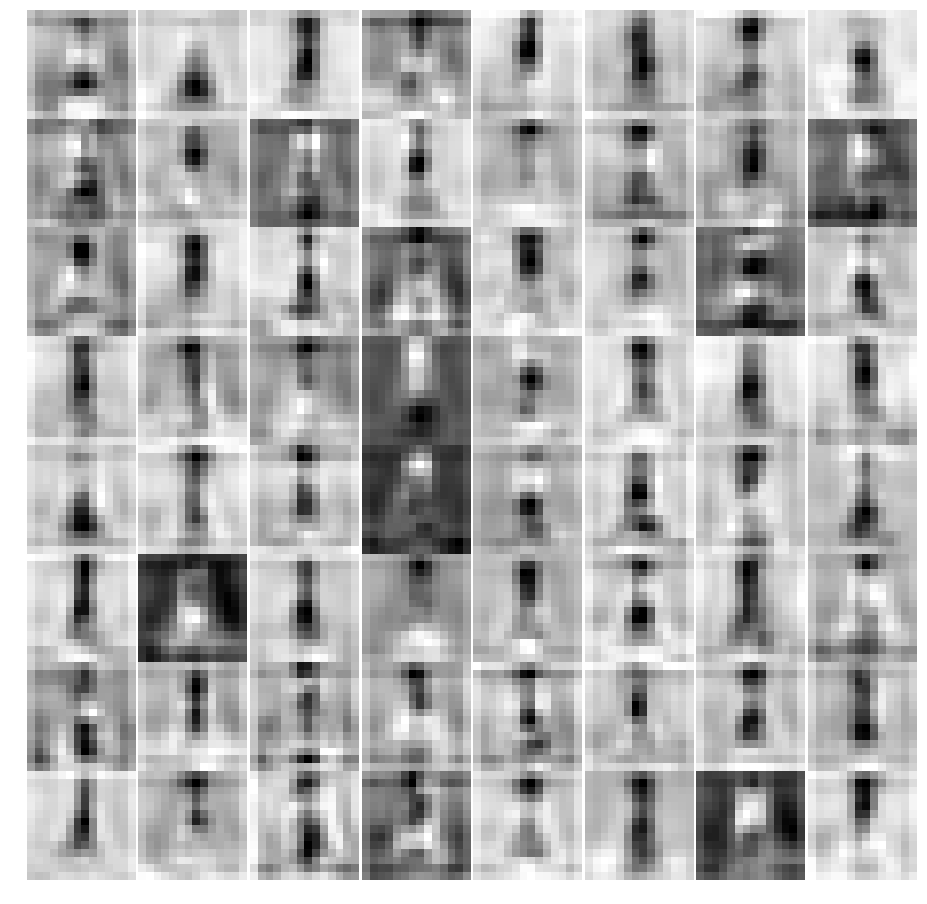

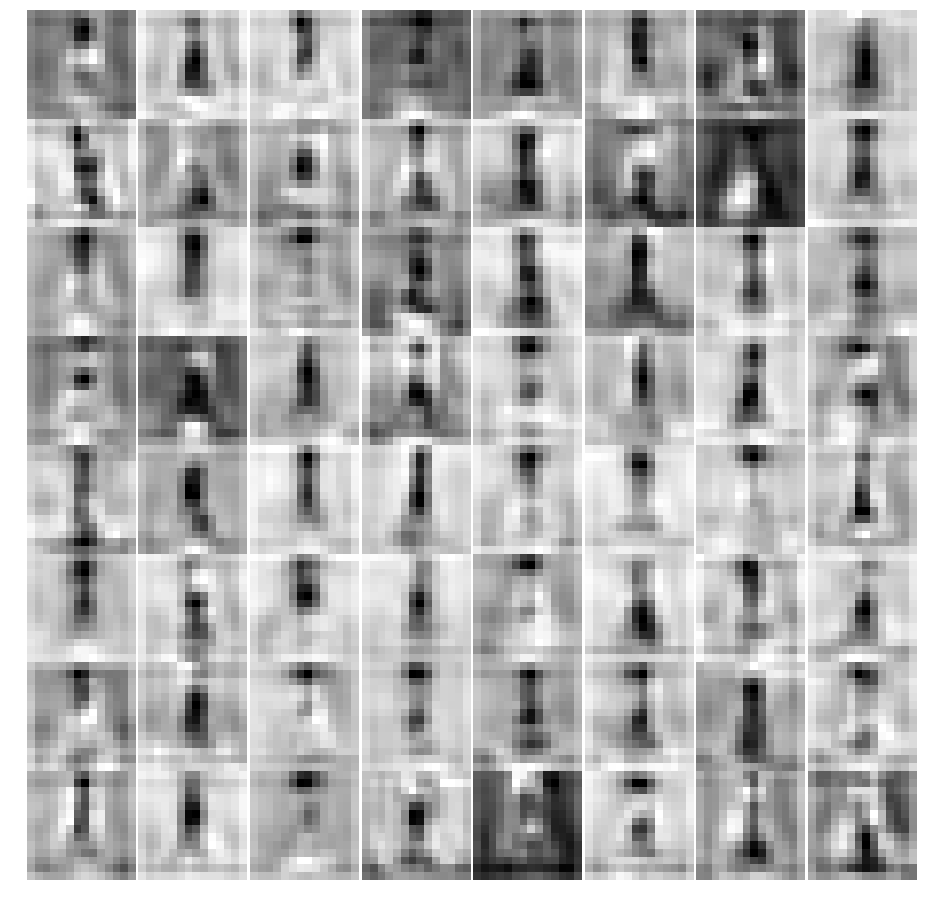

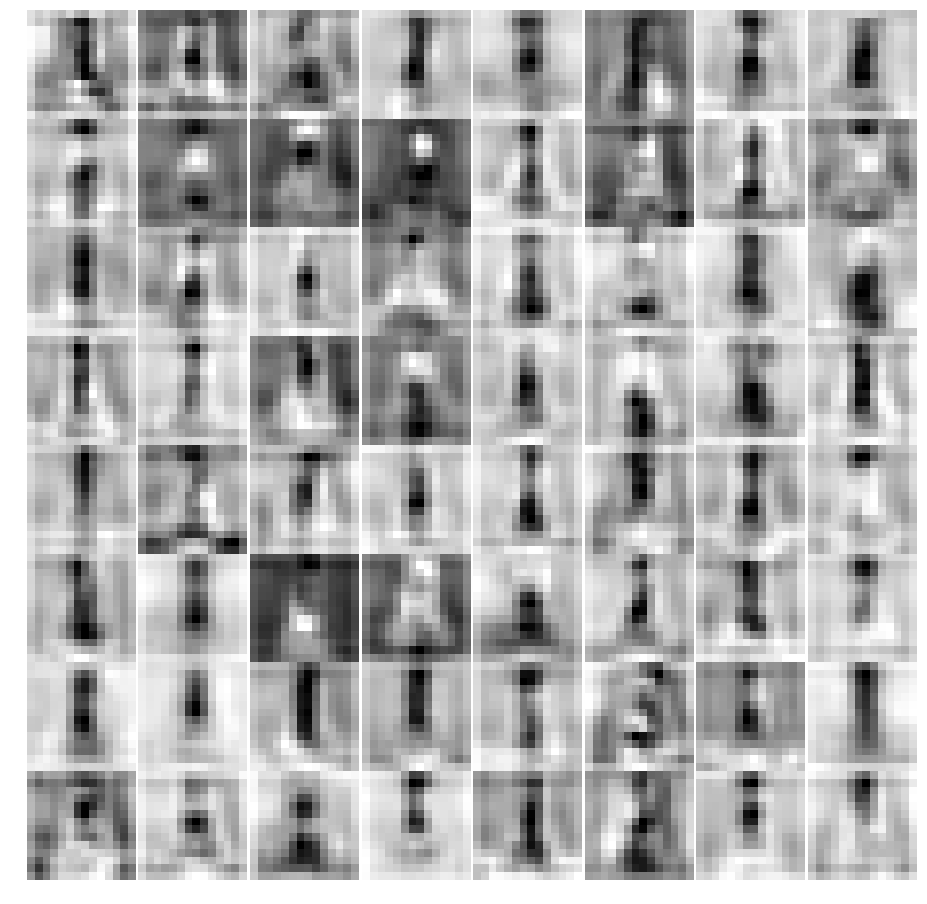

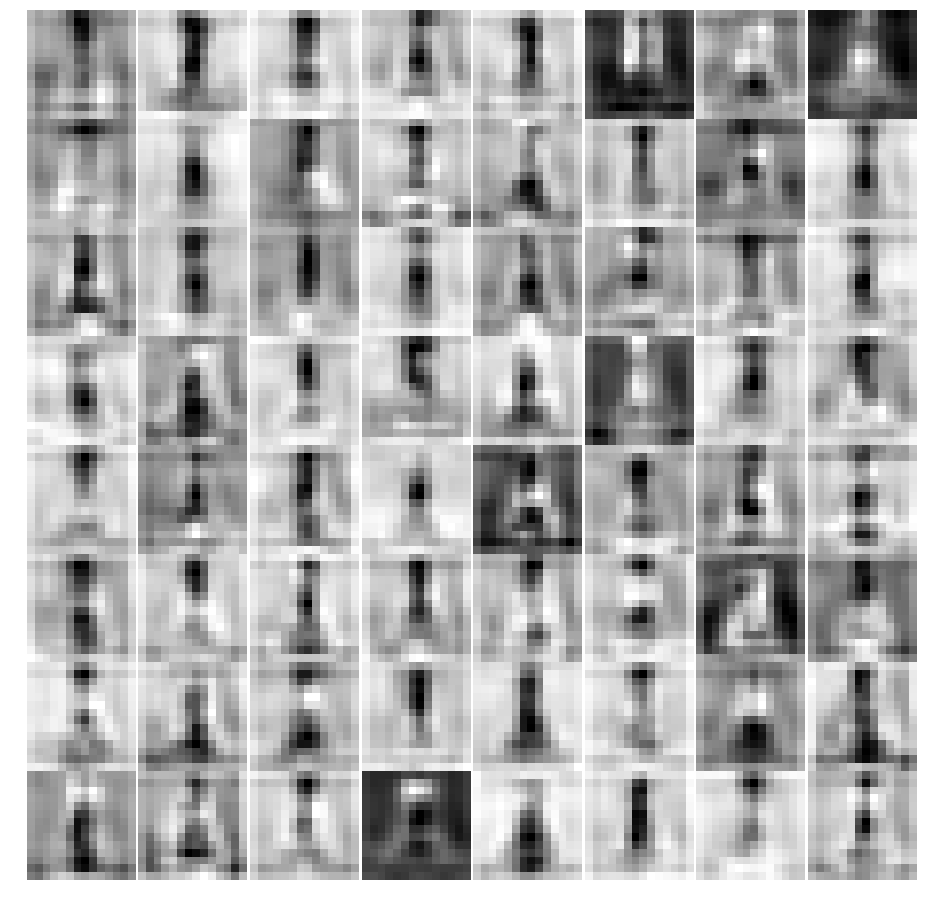

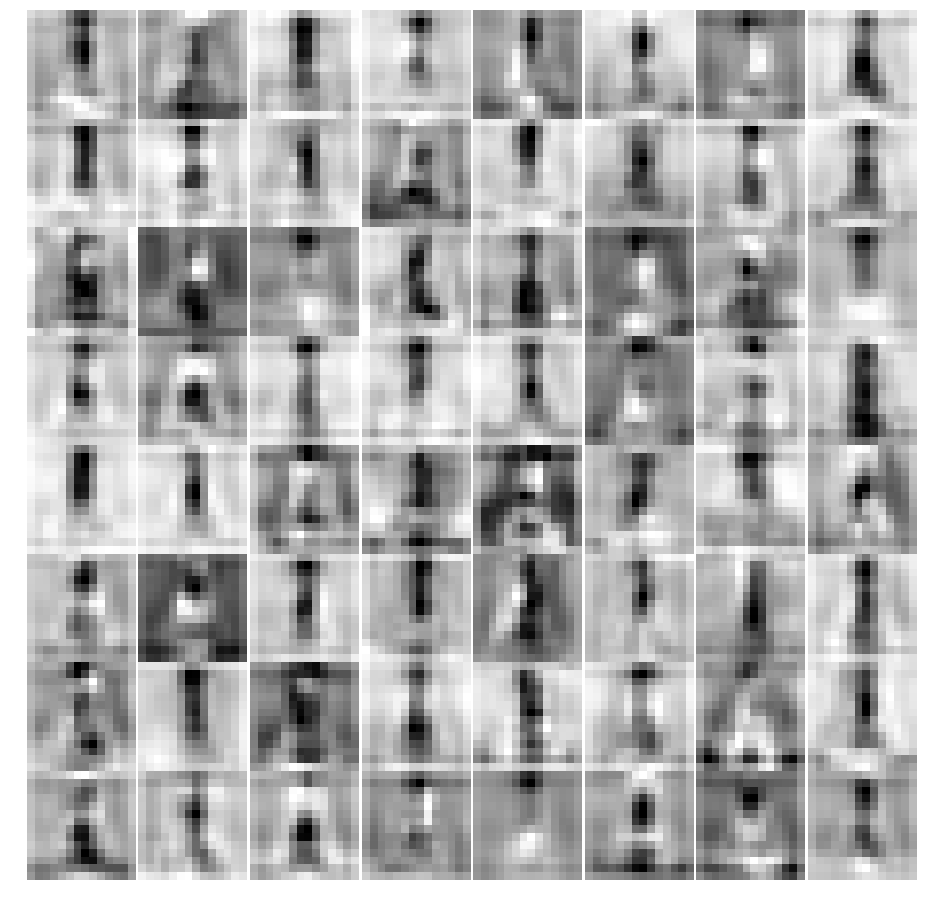

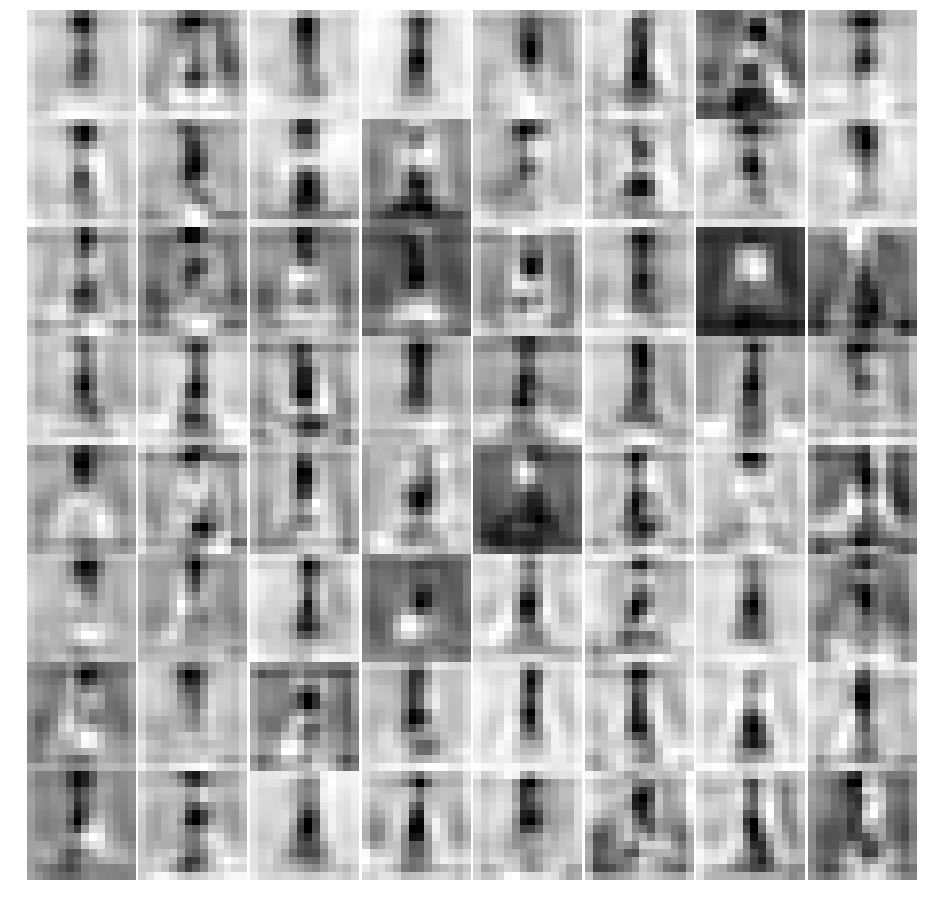

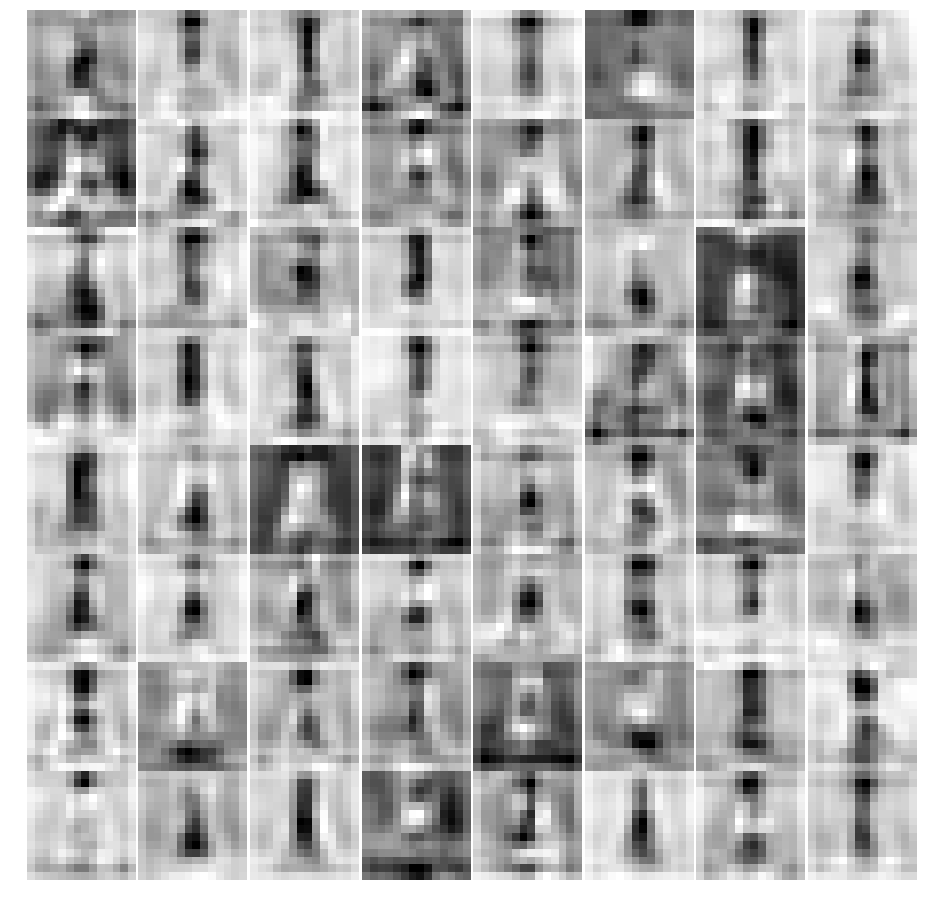

In [253]:
imshow_gray_last(grid.numpy())

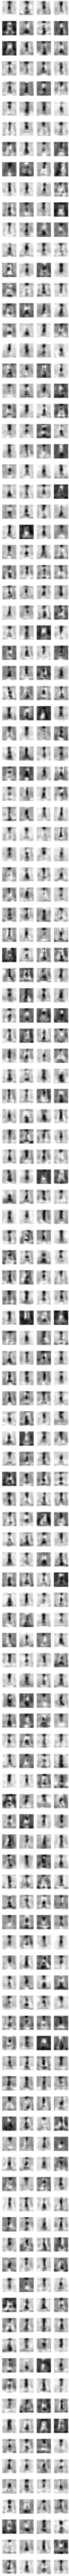

In [178]:
imshow_gray_last(grid.numpy())

In [174]:
plt.imshow(op2[0].transpose((1, 2, 0)))
plt.show()

TypeError: transpose received an invalid combination of arguments - got (tuple), but expected (int dim0, int dim1)

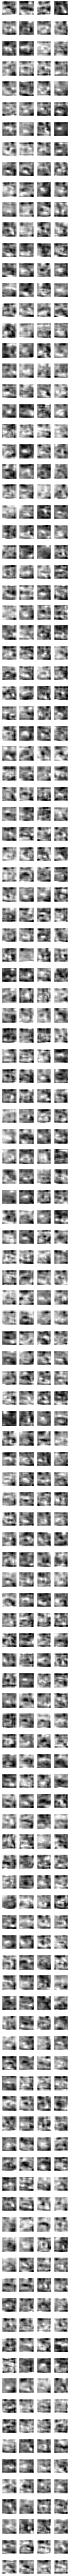

In [88]:
imshow_gray_last(grid.numpy())

In [164]:
grid[:3].numpy().shape

(3, 224, 224)

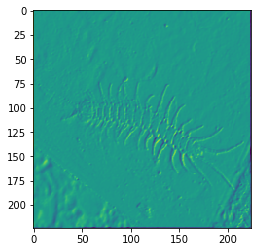

In [165]:
plt.imshow(grid[1].numpy())
plt.show()

In [166]:
grid[1].shape

torch.Size([224, 224])

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(grid[:3].numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
# temp.data.cpu().numpy().shape

In [138]:
# pretrained_model = torchvision.models.vgg16(pretrained=True)
# list(pretrained_model.classifier.children())[:]
# print(cnn)

In [139]:
cnn = VGG_modified()
for param in cnn.pretrained.parameters():
    param.requires_grad = False
    
for param in cnn.classifier.parameters():
    param.requires_grad = False
    
for param in cnn.lastlayer.parameters():
    param.requires_grad = True

cnn = cnn.cuda()

In [8]:
for m in cnn.lastlayer.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform(m.weight)
        print(m)

Linear (4096 -> 256)


In [9]:
print(cnn)

VGG_modified (
  (pretrained): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride

In [142]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt

In [143]:
layer1_weights=firstlayer_cnn.cpu().pretrained[0].weight.data
# plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)

In [144]:
grid=torchvision.utils.make_grid(layer1_weights, nrow=8, padding=1, \
                                 normalize=True, range=None, scale_each=False, pad_value=0)

In [153]:
grid.shape

torch.Size([3, 33, 33])

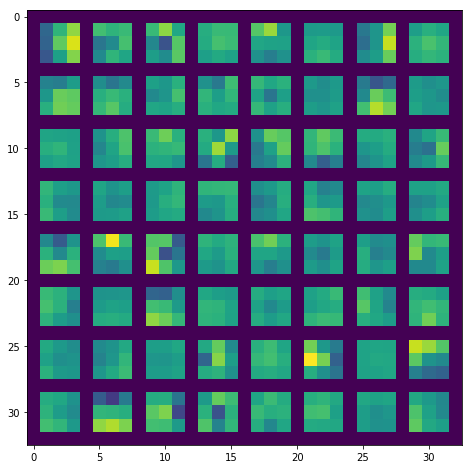

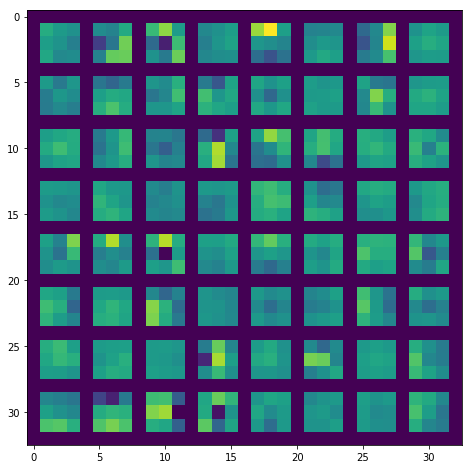

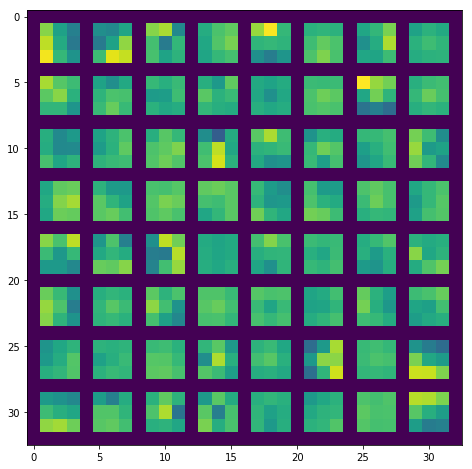

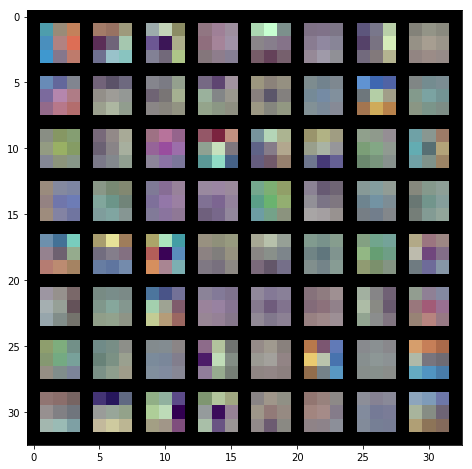

In [152]:
plt.figure(figsize=(8,8))
plt.imshow(grid[0].numpy())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(grid[1].numpy())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(grid[2].numpy())
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()